In [92]:
#https://nilearn.github.io/dev/glm/second_level_model.html
# Reminder : Multiple comparisons correction

import os
import glob
import nilearn 
import itertools
import numpy as np 
import pandas as pd
import nibabel as nib

from scipy.stats import norm
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.second_level import SecondLevelModel
from nilearn.datasets import fetch_localizer_contrasts
from nilearn.image import get_data, math_img
from nilearn.glm.second_level import non_parametric_inference


# Init variables
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
data_path = "/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/z_score/"

# Data path
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path = '/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'

# Paths for the directories
output_dir = '/project/4180000.19/multirat_stim/rabies_test/second_level_analysis/'
image_dir = os.path.join(output_dir, 'image/')
z_score_dir = os.path.join(output_dir, 'z_score/')
beta_dir = os.path.join(output_dir, 'beta_estimates/')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(z_score_dir):
    os.makedirs(z_score_dir)
if not os.path.exists(beta_dir):
    os.makedirs(beta_dir)

df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]


In [7]:
subject_label = int(np.matrix(df.iloc[9]['rat.sub']).A[0])
print(subject_label)

200109


5


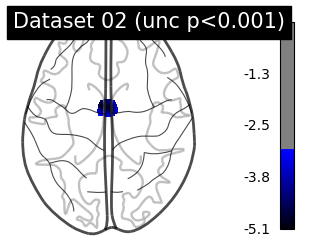

<Figure size 640x480 with 0 Axes>

In [131]:
#https://nilearn.github.io/dev/auto_examples/07_advanced/plot_bids_analysis.html 

ID = '02'   #need to be give input, e.g., 01-17, or loop ? 

dataset = glob.glob(data_path+'z_score_sub-02003??_ses-1.nii.gz')
n_subject = len(dataset)                                                           
print(n_subject)


second_level_input = dataset
design_matrix = pd.DataFrame([1] * len(second_level_input), 
                             columns=["intercept"])


# --- Specify the model and fit it --- 
second_level_model = SecondLevelModel(smoothing_fwhm=8.0,
                                      minimize_memory=False)

second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)


# --- Estimate the contrast --- 
second_stat_map = second_level_model.compute_contrast(second_level_contrast="intercept", output_type='all') 

nib.save(second_stat_map['z_score'], z_score_dir+'z_score_sub-{}_ses-1.nii.gz'.format(ID))          #save z map
nib.save(second_stat_map['effect_size'], beta_dir+'beta_sub-{}_ses-1.nii.gz'.format(ID))            #save the betaestimates


p_val = 0.001
p001_unc = norm.isf(p_val)
display = plotting.plot_glass_brain(second_stat_map['z_score'],
                                    threshold=p001_unc,
                                    colorbar=True,
                                    display_mode="z",
                                    plot_abs=False,
                                    title="Dataset {} (unc p<0.001)".format(ID))

plotting.show()
plt.savefig(image_dir+'stat_map_dataset-{}_ses-1.png'.format(ID))


In [110]:

p_val = second_stat_map['p_value']
n_voxels = np.sum(get_data(second_level_model.masker_.mask_img_))


# Correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img(f"-np.log10(np.minimum(1, img * {str(n_voxels)}))",
                        img=p_val)

print(neg_log_pval)
out_dict = non_parametric_inference(second_level_input,
                                    design_matrix=design_matrix,
                                    model_intercept=True,
                                    n_perm=500,                      # 500 for the sake of time. Ideally, this should be 10,000.
                                    two_sided_test=False,
                                    smoothing_fwhm=8.0,
                                    n_jobs=1,
                                    threshold=0.001)




<string>:1: RuntimeWarning: divide by zero encountered in log10
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:958: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/masking.py:858: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [ ]:
print(neg_log_pval)
print(out_dict["logp_max_t"])
print(out_dict["logp_max_size"])

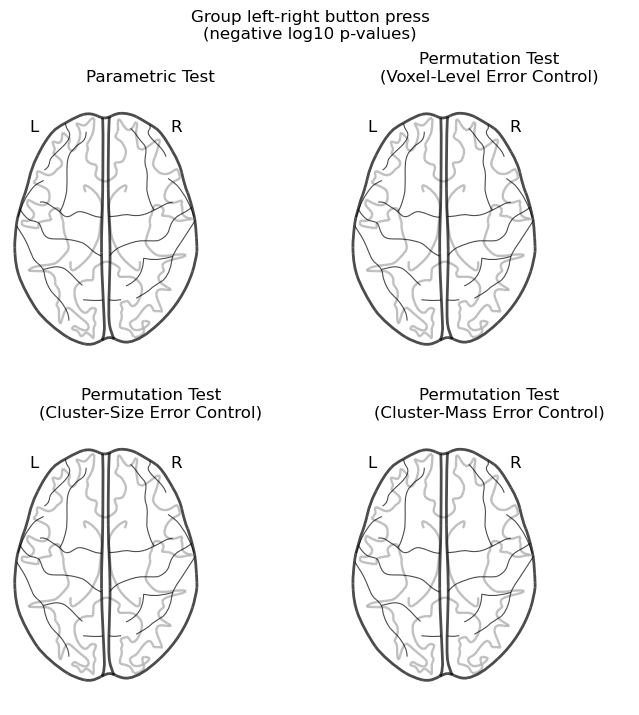

In [125]:

threshold = 1    # p < 0.1
vmax = 2.69       # ~= -np.log10(1 / 500)

cut_coords = [0]

IMAGES = [neg_log_pval,
          out_dict["logp_max_t"],
          out_dict["logp_max_size"],
          out_dict["logp_max_mass"]]

TITLES = ["Parametric Test",
          "Permutation Test\n(Voxel-Level Error Control)",
          "Permutation Test\n(Cluster-Size Error Control)",
          "Permutation Test\n(Cluster-Mass Error Control)"]

fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)


for img_counter, (i_row, j_col) in enumerate(itertools.product(range(2), range(2))):
    ax = axes[i_row, j_col]
    plotting.plot_glass_brain(IMAGES[img_counter],
                            colorbar=True,
                            vmax=vmax,
                            display_mode="z",
                            plot_abs=False,
                            cut_coords=cut_coords,
                            threshold=threshold,
                            figure=fig,
                            axes=ax)
    
    ax.set_title(TITLES[img_counter])

fig.suptitle("Group left-right button press\n(negative log10 p-values)")

plt.show()
# plt.savefig(image_dir+'stat_map_sub-{}_ses-1.png'.format(ID))

